In [ ]:
!pip install gshap

In [39]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from gshap.intergroup import IntergroupDifference
import seaborn as sns
import gshap
from gshap.datasets import load_recidivism

recid = load_recidivism()
X, y = recid.data, recid.target

In [40]:
group = X['black']

X = X.drop(columns=['black'])

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, group, test_size=1000, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6004 - loss: 0.6569 - val_accuracy: 0.6760 - val_loss: 0.6038
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6535 - loss: 0.6239 - val_accuracy: 0.6870 - val_loss: 0.5976
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6634 - loss: 0.6112 - val_accuracy: 0.6890 - val_loss: 0.5946
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6715 - loss: 0.6052 - val_accuracy: 0.6890 - val_loss: 0.5944
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6631 - loss: 0.6173 - val_accuracy: 0.6820 - val_loss: 0.5928
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6691 - loss: 0.6097 - val_accuracy: 0.6920 - val_loss: 0.5953
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6766 - loss: 0.6072 - val_accuracy: 0.6900 - val_loss: 0.5916
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6681 - loss: 0.6081 - val_accuracy: 0.6890 - v

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


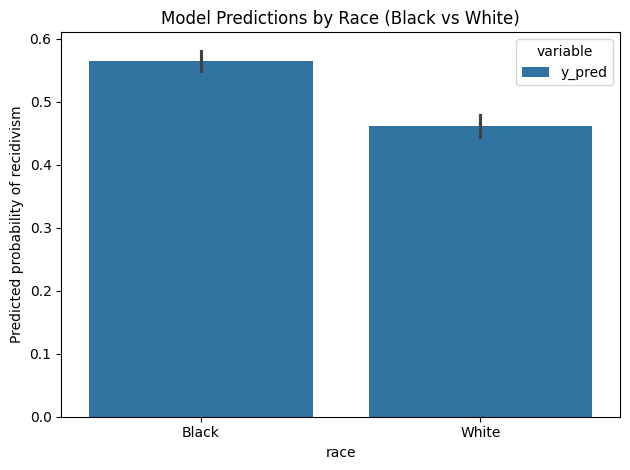

In [42]:
y_pred_test = model.predict(X_test_scaled).flatten()

df_pred = pd.DataFrame({
    'race': group_test.replace({1: 'Black', 0: 'White'}).values,
    'y_pred': y_pred_test
})
df_pred['id'] = df_pred.index
df_melt = df_pred.melt(id_vars=['id', 'race'], value_vars=['y_pred'])

sns.barplot(x='race', y='value', hue='variable', data=df_melt)
plt.ylabel('Predicted probability of recidivism')
plt.title('Model Predictions by Race (Black vs White)')
plt.tight_layout()
plt.show()

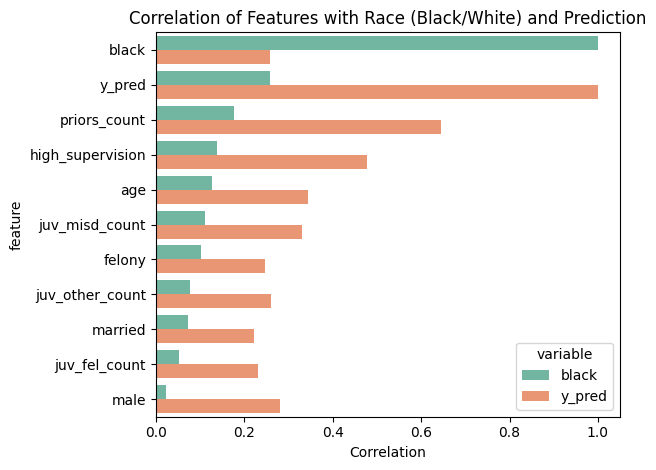

In [43]:
df_corr = pd.concat([X_test.reset_index(drop=True), group_test.reset_index(drop=True)], axis=1)
df_corr['black'] = group_test.reset_index(drop=True)
df_corr['y_pred'] = y_pred_test

corr_matrix = df_corr.corr()
corr_subset = corr_matrix[['black', 'y_pred']].abs().sort_values(by='black', ascending=False).head(20)
corr_subset = corr_subset.reset_index().rename(columns={'index': 'feature'})

corr_melt = corr_subset.melt(id_vars='feature', value_vars=['black', 'y_pred'], var_name='variable', value_name='correlation')

sns.barplot(x='correlation', y='feature', hue='variable', data=corr_melt, palette='Set2')
plt.xlabel('Correlation')
plt.title('Correlation of Features with Race (Black/White) and Prediction')
plt.tight_layout()
plt.show()

In [44]:
predict_fn = lambda x: model(x, training=False).numpy().flatten()

sample_X = X_test_scaled[:100]
sample_group = group_test[:100]
background_X = X_train_scaled[:50]

g = IntergroupDifference(group=sample_group, distance="relative_mean_distance")
explainer = gshap.KernelExplainer(predict_fn, background_X, g)

gshap_values = explainer.gshap_values(sample_X, nsamples=50)

df_importance = pd.DataFrame({'Features': X.columns, 'G-SHAP': gshap_values})
df_importance = df_importance.sort_values('G-SHAP', ascending=False)

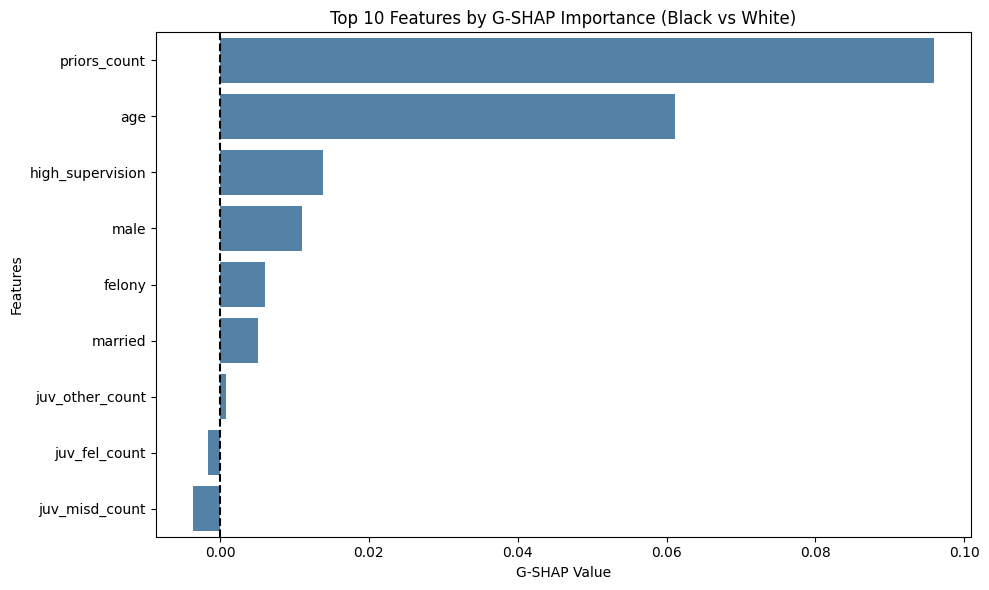


G-SHAP Summary Table (Top Features):


,Features,G-SHAP
5,priors_count,0.095941
1,age,0.061096
8,high_supervision,0.013812
0,male,0.011007
6,felony,0.006043
7,married,0.005035
4,juv_other_count,0.000820
2,juv_fel_count,-0.001638
3,juv_misd_count,-0.003638


In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='G-SHAP', data=df_importance.head(20), color='steelblue')
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 10 Features by G-SHAP Importance (Black vs White)")
plt.xlabel("G-SHAP Value")
plt.tight_layout()
plt.show()

print("\nG-SHAP Summary Table (Top Features):")
display(df_importance.head(20))